# Рынок заведений общественного питания Москвы
**Описание проекта**  
Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов? Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.  
  
### Оглавление
[Шаг 1. Загрузка и предобработка данных](#1)
- [Загрузка библиотек](#1_1) 
- [Загрузка данных](#1_2) 
- [Предобработка данных](#1_3) 
- [Обработка названий](#1_4) 
- [Обработка адресов](#1_5) 

[Шаг №2. Анализ данных](#2)
- [Соотношение количества заведений по виду и сетевым / несетевым](#2_1) 
- [Для какого вида объекта общественного питания характерно сетевое распространение?](#2_2) 
- [Что характерно для сетевых заведений?](#2_3) 
- [Среднее количество посадочных мест для каждого вида объекта ](#2_4)  
- [Топ-10 улиц по количеству объектов общественного питания](#2_5) 
- [Улицы с одним объектом общественного питания](#2_7) 
- [Распределение количества посадочных мест](#2_7) 
- [Общий вывод](#2_8)

[Шаг №3. Презентация](#3)

## Шаг 1. Загрузка и предобработка данных <a id="1"></a> 

### Загрузка библиотек <a id="1_1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re
from collections import Counter
import requests
from bs4 import BeautifulSoup

### Загрузка данных <a id="1_2"></a>

In [2]:
df = pd.read_csv('/datasets/rest_data.csv')
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропусков нет, типы данных корректны.  
**Описание данных**  
object_name — название объекта общественного питания;  
chain — сетевой ресторан;  
object_type — тип объекта общественного питания;  
address — адрес;  
number — количество посадочных мест.

### Предобработка данных <a id="1_3"></a>  
**Переименовываю столбцы**

In [4]:
df.columns = ['id', 'name', 'chain', 'type', 'address', 'seats'] 

**Проверяю наличие дубликатов:**

In [5]:
print(len(df[df.duplicated() == True]))
print(len(df[df.duplicated('id') == True]))
print(len(df[df.duplicated(['name', 'address'], keep = False) == True]))

0
0
344


In [6]:
pd.set_option('max_colwidth', 100)
df[df.duplicated(['name', 'address'], keep = False) == True]\
    .groupby(['name', 'address'], as_index = False)['id'].count().sort_values(by='id', ascending = False).head()

,name,address,id
46,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,"город Москва, 2-я Бауманская улица, дом 5, строение 1",11
54,Кафе,"город Москва, 1-я Останкинская улица, дом 55",9
89,Лиор,"город Москва, Шарикоподшипниковская улица, дом 13, строение 3",8
64,Кафе,"город Москва, Тихорецкий бульвар, владение 1, строение 1",6
7,LIFT,"город Москва, Багратионовский проезд, дом 7, корпус 1",6


In [7]:
df[df.duplicated(['name', 'address'], keep = False) == True].groupby(['name', 'address'], as_index = False)['id']\
.count().sort_values(by='id', ascending = False).head()

,name,address,id
46,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,"город Москва, 2-я Бауманская улица, дом 5, строение 1",11
54,Кафе,"город Москва, 1-я Останкинская улица, дом 55",9
89,Лиор,"город Москва, Шарикоподшипниковская улица, дом 13, строение 3",8
64,Кафе,"город Москва, Тихорецкий бульвар, владение 1, строение 1",6
7,LIFT,"город Москва, Багратионовский проезд, дом 7, корпус 1",6


In [8]:
df[df['address'] == 'город Москва, 2-я Бауманская улица, дом 5, строение 1']

,id,name,chain,type,address,seats
2374,28603,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",100
2375,28604,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",150
2376,28605,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,кафетерий,"город Москва, 2-я Бауманская улица, дом 5, строение 1",35
2377,28606,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,буфет,"город Москва, 2-я Бауманская улица, дом 5, строение 1",16
2378,28607,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,закусочная,"город Москва, 2-я Бауманская улица, дом 5, строение 1",16
2379,28609,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,буфет,"город Москва, 2-я Бауманская улица, дом 5, строение 1",30
2380,28610,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",200
2381,28611,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",100
2382,28615,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",168
2383,28616,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,закусочная,"город Москва, 2-я Бауманская улица, дом 5, строение 1",64


Вывод: в популяции из 15366 значений есть 344, для которых дублируются название и адрес. На примере комбината питания Бауманки видно, что это явно одно заведение, но с разными типами и количеством мест. Учитывая количество дубликатов, можно просто удалить их, оставив в популяции первые строки:

In [9]:
df = df.drop_duplicates(subset = ['name', 'address']).reset_index(drop=True)

**Проверяю значения отдельных столбцов:**  

In [10]:
for column in ['chain', 'type']:
    print(df[column].unique())

['нет' 'да']
['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']


Для краткости переименовываю некоторые виды заведений:

In [11]:
df['type'] = df['type'].replace('предприятие быстрого обслуживания', 'фастфуд')
df['type'] = df['type'].replace('магазин (отдел кулинарии)', 'кулинария')

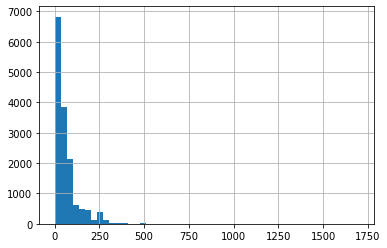

In [12]:
df['seats'].hist(bins = 50)

In [13]:
len(df[df['seats'] > 500])

24

In [14]:
df.sort_values(by = 'seats', ascending = False).head()

,id,name,chain,type,address,seats
12595,199696,Arena by Soho Family,нет,бар,"город Москва, Кутузовский проспект, дом 36, строение 11",1700
8062,80291,Банкетный зал Шелк,нет,ресторан,"город Москва, Большой Саввинский переулок, дом 12, строение 10Г",1500
8259,27750,СТОЛОВАЯ-БУФЕТ,нет,столовая,"город Москва, улица Волхонка, дом 15",1400
8973,19719,КОМБИНАТ ПИТАНИЯ «УПРАВЛЕНИЕ АКАДЕМСЕРВИС»,нет,столовая,"город Москва, проспект Вернадского, дом 84, строение 1",1288
4451,27024,РУМ СЕРВИС,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, строение 1",1200


Высокие значения выглядят реалистичными. Arena by Soho Family - это бар, расположенный на стадионе, то есть здесь указано не количество посадочных мест, а количество посетителей. Данные некорректны, но не из-за источника собранных данных, а из-за неправильной интерпретации. Для анализа ресторанов по количеству мест нужно будет использовать очищенные данные, держа во внимании возможные неправильные интерпретации этого показателя, но исключать эти данные не нужно.  

### Обработка названий  <a id="1_4"></a>  
Названия сетей могут иметь разный формат. Для анализа необходимо унифицировать их:

In [15]:
df['name'] = df['name'].str.lower()
for i in ['»', '«', '.']:
    df['name'] = df['name'].str.replace(i, '')
df['name'] = df['name'].str.replace('ё', 'е')

Далее я провожу лемматизацию и выделяю наиболее популярные названия:

In [16]:
words = (df['name'].str.cat(sep=' ').split())
lemmas = pd.Series(Counter(words), name='lemmas').sort_values(ascending = False)

In [17]:
lemmas[:20]

кафе           1658
столовая       1562
школа           653
ресторан        593
при             592
№               513
гбоу            455
пицца           365
бар             314
шаурма          308
буфет           286
суши            252
кофе            232
пекарня         212
и               195
бургер          195
шоколадница     186
kfc             186
макдоналдс      168
кинг            166
Name: lemmas, dtype: int64

Проверяю, все ли Шоколадницы названы одинаково:

In [18]:
df[np.logical_and(
        df['name']!='шоколадница',
        df['name'].str.contains('шоколадница'))].head()

,id,name,chain,type,address,seats
271,25141,шоколадница кофе хаус,да,кафе,"город Москва, Тверская улица, дом 17",60
586,134332,кофейня шоколадница,да,кафе,"город Москва, Ленинский проспект, дом 37А",43
882,21774,кафе шоколадница,да,кафе,"город Москва, улица Шаболовка, дом 30/12",48
1731,69008,кафе шоколадница,нет,кафе,"город Москва, Ломоносовский проспект, дом 25, корпус 1",50
1818,24304,кафе шоколадница,да,кафе,"город Москва, улица Большие Каменщики, дом 2",67


Как видно, чтобы корректно отслеживать сетевые заведения, нужно привести их названия к названию сети. Для этого пишу функции, которые убирают общие названия (кафе, столовая, ресторан) из названия, и переименовывает сети:

In [19]:
def names_normaliser(name):

    for i in ['кафе', 'столовая', 'ресторан']:
        if i == name:
            return name
        else: 
            new_name = name.replace(i, '')
            return new_name

def chains_normaliser(name):
        
    for chain_name in ['шоколадница', 'бургер кинг', 'макдоналдс', 'kfc', 'теремок', 'домино', 'крошка картошка',
                      'subway', 'starbucks', 'му-му', 'cofix', 'кулинарная лавка братьев караваевых', 'якитория', 
                       'мята lounge', 'coffeeshop', 'буше', 'прайм стар', 'иль патио', 'маки-маки', 'ваби-саби', 
                       'ванвок', 'costa coffee', 'штолле', 'папа джонс', 'икеа', 'суши wok', 'гудман']:
        if chain_name in name:
            name = chain_name
    return name

In [20]:
print(len(df[df['chain'] == 'да'].groupby('name', as_index = False)['id'].count().query('id == 1')))
df['name'] = df['name'].apply(names_normaliser)
df['name'] = df['name'].apply(chains_normaliser)
print(len(df[df['chain'] == 'да'].groupby('name', as_index = False)['id'].count().query('id == 1')))

308
234


В результате применения функции количество заведений, которые отмечены как сетевые, но с уникальным названием, сократилось на треть. Все названия максимально унифицированы. 

 
### Обработка адресов  <a id="1_5"></a>  
Чтобы обрабатывать адреса, нужно привести их к одном формату. Для начала удаляю "город Москва" из названия, так как все завадения и так по умолчанию в Москве:

In [21]:
df['address'] = df['address'].str.replace('город Москва, ', '')

Далее я добавляю отдельный столбец с городом. По умолчанию он равен Москве, кроме других городов.

In [22]:
def city(address):
    if 'Зеленоград' in address:
        address = 'Зеленоград'
    elif 'Московский' in address:
        address = 'Московский'
    elif 'Щербинка' in address:
        address = 'Щербинка'
    elif 'Троицк' in address:
        address = 'Троицк'
    else: address = 'Москва'
    return address

In [23]:
df['city'] = df['address'].apply(city)

In [24]:
df.groupby('city')['id'].count()

city
Зеленоград      232
Москва        14681
Московский      134
Троицк           65
Щербинка         47
Name: id, dtype: int64

In [25]:
for i in ['город Зеленоград, ', 'город Московский, ', 'город Щербинка, ', 'город Троицк, ','город Москва, ']:
    df['address'] = df['address'].str.replace(i, '')

In [26]:
df.head(2)

,id,name,chain,type,address,seats,city
0,151635,сметана,нет,кафе,"улица Егора Абакумова, дом 9",48,Москва
1,77874,родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35,Москва


Теперь в начале строки адреса до запятой, как правило, идет название улицы. Выделяю ее в отдельный столбец:

In [27]:
df['street'] = df['address'].str.split(',',expand=True)[0]
df.head(2)

,id,name,chain,type,address,seats,city,street
0,151635,сметана,нет,кафе,"улица Егора Абакумова, дом 9",48,Москва,улица Егора Абакумова
1,77874,родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35,Москва,улица Талалихина


Предобработка завершена.

## Шаг №2. Анализ данных  <a id="2"></a>

### Соотношение количества заведений по виду и сетевым / несетевым <a id="2_1"></a>  

Text(0, 0.5, 'Количество заведений')

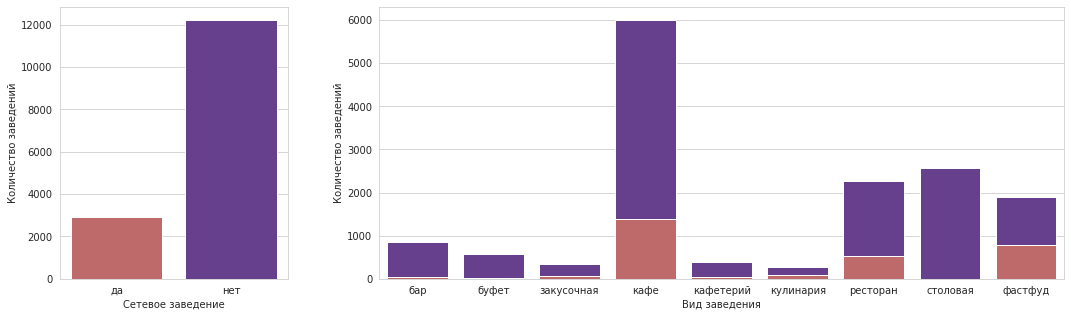

In [28]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,5), gridspec_kw={'width_ratios': [1, 3]})
sns.barplot(x='chain', y='id', data=df.groupby('chain', as_index = False)['id'].count(), ax = axes[0], 
            palette =['indianred', 'rebeccapurple'])
axes[0].set_xlabel('Сетевое заведение')
axes[0].set_ylabel('Количество заведений')
sns.barplot(x='type', y='id', data = df.groupby('type', as_index = False)['id'].count(), color='rebeccapurple', ax = axes[1])
sns.barplot(x='type', y='id', data = df.groupby(['type', 'chain'], as_index = False)['id'].count().query('chain == "да"'), 
            color='indianred', ax = axes[1])
axes[1].set_xlabel('Вид заведения')
axes[1].set_ylabel('Количество заведений')

Основные выводы:
- 19% заведений - сетевые, 81% - несетевые
- 6 тысяч заведений - кафе, примерно по 2 тысячи - столовые, рестораны и фастфуд, остальных - меньше 1 тысячи
- соотношение сетевых и несетвых заведений для каждого вида можно посмотреть отдельно

### Для какого вида объекта общественного питания характерно сетевое распространение? <a id="2_2"></a>  

In [29]:
bytypechain = df.pivot_table(index = 'type', columns = 'chain', values = 'id', aggfunc = 'count').reset_index()
bytypechain = bytypechain.append(pd.DataFrame([['в среднем', bytypechain['да'].sum(), bytypechain['нет'].sum()]], 
                                              columns = ['type', 'да', 'нет']))
bytypechain['%сетей'] = bytypechain['да'] / (bytypechain['да'] + bytypechain['нет']) 
bytypechain = bytypechain.sort_values(by = '%сетей', ascending = False).reset_index()
bytypechain['100%'] = 1

In [30]:
bytypechain.head()

chain,index,type,да,нет,%сетей,100%
0,8,фастфуд,782,1104,0.414634,1
1,5,кулинария,78,194,0.286765,1
2,6,ресторан,539,1733,0.237236,1
3,3,кафе,1384,4619,0.230551,1
4,0,в среднем,2940,12219,0.193944,1


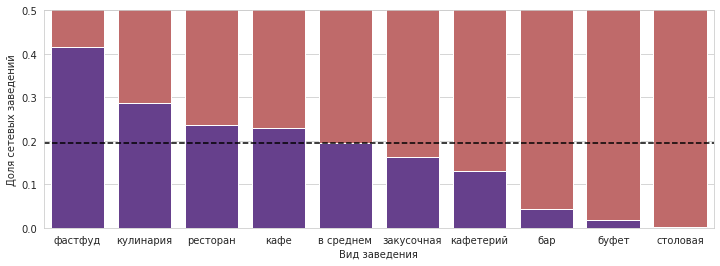

In [31]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(x='type', y='100%', data = bytypechain, color='indianred')
ax = sns.barplot(x='type', y='%сетей', data = bytypechain, color='rebeccapurple')
ax.set_xlabel('Вид заведения')
ax.set_ylabel('Доля сетевых заведений')
ax.set_ylim(0,0.5)
plt.axhline(y=bytypechain.loc[4, '%сетей'], color='black', linestyle='--')

- в среднем доля сетевых заведений - 19%
- наивысшая доля у фастфуда - больше 40%, чуть выше среднего - у кулинарий, ресторанов и кафе, ниже 19% у закусочных, кафетериев, баров, буфетов
- сетевых столовых нет вообще 

### Что характерно для сетевых заведений?  <a id="2_3"></a>  
Много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

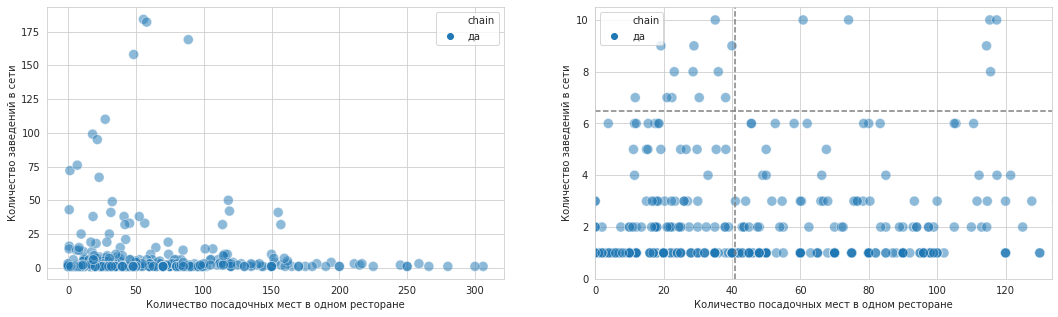

In [32]:
namechain = df[df['chain'] == 'да'].groupby(['name', 'chain'], as_index = False).agg({'id':'count', 'seats':'sum'})
namechain['seats_per_rest'] = namechain['seats'] / namechain['id']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,5))
sns.scatterplot(x="seats_per_rest", y="id", hue = 'chain', alpha = 0.5, s = 100, data = namechain, ax = axes[1])
axes[1].set_xlim(0,namechain['seats_per_rest'].quantile(0.9))
axes[1].set_ylim(0,namechain['id'].quantile(0.9)+0.5)
axes[1].set_xlabel('Количество посадочных мест в одном ресторане')
axes[1].set_ylabel('Количество заведений в сети')

sns.scatterplot(x="seats_per_rest", y="id", hue = 'chain', alpha = 0.5, s = 100, data = namechain, ax = axes[0])
axes[0].set_xlabel('Количество посадочных мест в одном ресторане')
axes[0].set_ylabel('Количество заведений в сети')
plt.axhline(y=6.5, color='grey', linestyle='--')
plt.axvline(x=41, color='grey', linestyle='--')

Первый график - полный, второй - ограничен до 90 перцентиля по обоим показателям, чтобы учитывать только нормальные данные. По правом (нормализованному) графику можно сделать выводы:
- Несмотря на приведение названий заведений к единому формату, большая часть сетевых заведений имеет только 1 заведение. Это может быть как из-за того, разные заведения названы по-разному, так и из-за неполных данных, или того, что другие заведения находятся в других регионах. Это нельзя считать ошибкой.
- У большинства сетей 1-2 заведения и до 50 посадочных мест.
- За редкими исключениями, второе и следующие заведения появляются при среднем количестве от 10 мест, то есть некоторые маленькие заведения увеличивают количество, но не размер. 
- Можно выделить две группы сетей с сумарным количеством мест от 200: первые - 6-10 заведений до 40 мест каждое, вторые - 40-120 мест в 1-6 заведении. Сетей, где было бы больше и 6 заведений, и 40 мест в каждом, очень мало.
- То есть можно говорить о том, что заведения до 40 мест расширяют сеть, а большие (больше 40 мест) ограничиваются 1-3, реже - до 6, причем вторых больше.  
На левом графике видно, что тенденция сохраняется: большие сети (>50 заведений) ограничены 50-60 местами (за одним исключением), а большие заведения не масштабируются.   
В итоге, можно говорить о двух стратегиях, причем сетей с несколькими большими ресторанами гораздо больше, чем больших сетей с небольшими ресторанами. 

### Среднее количество посадочных мест для каждого вида объекта <a id="2_4"></a>  
Какой вид предоставляет в среднем самое большое количество посадочных мест?

Text(17.231250000000003, 0.5, 'Количество заведений')

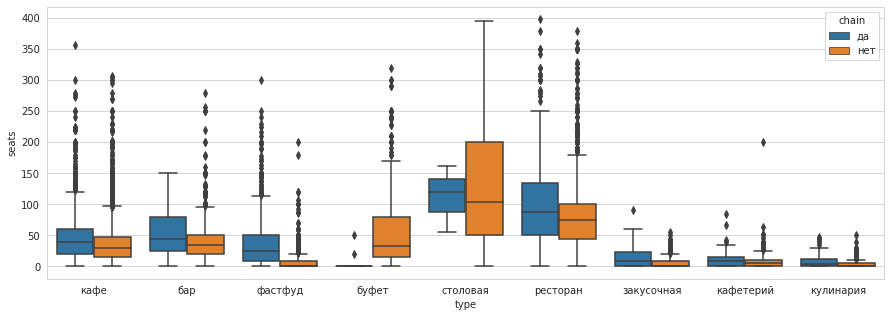

In [33]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="type", y="seats", hue = 'chain', 
            data=df.groupby(['id', 'type', 'chain'], as_index = False)['seats'].sum().query('seats < 400'))
ax.set_xlabel('Вид заведения')
ax.set_ylabel('Количество заведений')

График ограничен сверху 400 местами.
- для большинства типов заведений характерно то, что в сетевых заведениях больше мест, чем в несетевых - как по медиане, так и по верхним значениями; исключением являются буфеты и столовые, которые почти не бывают сетевыми, и рестораны; 
- закусочные, кафетерии и кулинарии, как и следовало ожидать, очень маленькие - половина не достигает 10 человек;
- медиана кафе, баров и фастфудов ниже 50 человек;
- самые большие - рестораны и столовые, их медиана близка к 100 людям. Рестораны также являются единственной категорией, в которые сетевые больше, чем несетевые.

### Топ-10 улиц по количеству объектов общественного питания <a id="2_5"></a>  
Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?  

Для начала загружаю классификатор улиц Москвы с data.mos.ru и подтягиваю их к основной таблице:

In [34]:
mosopen = pd.read_excel('mosopen.xlsx')
mosopen = mosopen.drop_duplicates(subset = 'UM_NAMEF').reset_index(drop=True)
mosopen.head(2)

,UM_NAMEF,UM_CODE
0,1-й Ирининский переулок,8880
1,2-й Ирининский переулок,8890


In [35]:
df = df.merge(mosopen, left_on='street', right_on='UM_NAMEF', how = 'left')
del df['UM_NAMEF']
df.columns = ['id', 'name', 'chain', 'type', 'address', 'seats', 'city', 'street','code']
df['code'] = df['code'].astype(str)
df.head(2)

,id,name,chain,type,address,seats,city,street,code
0,151635,сметана,нет,кафе,"улица Егора Абакумова, дом 9",48,Москва,улица Егора Абакумова,10.0
1,77874,родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35,Москва,улица Талалихина,27540.0


In [36]:
print('Удалось подтянуть код для {:.0%} улиц'.format(1-df['code'].isnull().sum() / len(df)))

Удалось подтянуть код для 100% улиц


Парсер собирает данные по району с сайта mosopen.ru, добавляю их в отдельный столбец (после первого использования сохраняю результат в файл и оставляю код запуска парсинга закомментированным): 

In [37]:
def districts(i):
    try:
        main_url = 'http://mosopen.ru/street/'
        url = main_url + i + '/'
        req = requests.get(url)
        soup = BeautifulSoup(req.text, 'lxml')
        div = soup.find('div', id = 'content')
        paragraphs = div.find_all('p')
        a = paragraphs[1].find_all('a')
        district = a[0].text
        return district
    except:
        return None

In [38]:
#df['district'] = df['code'].apply(districts)

Сохраняю результат в файл:

In [39]:
#df.to_csv('df.csv') 

In [40]:
df = pd.read_csv('df.csv')
del df['Unnamed: 0']
df.head(2)

,id,name,chain,type,address,seats,city,street,code,district
0,151635,сметана,нет,кафе,"улица Егора Абакумова, дом 9",48,Москва,улица Егора Абакумова,10.0,Ярославском районе
1,77874,родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35,Москва,улица Талалихина,27540.0,Нижегородский


In [41]:
undstrc = df['district'].nunique()
df['district'] = df['district'].str.replace('районе ', '')
df['district'] = df['district'].str.replace(' районе', '')
df['district'] = df['district'].str.replace('Тверском', 'Тверской')
df['district'] = df['district'].str.replace('ком', 'кий')
df['district'] = df['district'].str.replace('Басманном', 'Басманный')
df['district'] = df['district'].str.replace('Савёлки, районе Орехово-Борисово Северное, ', 'Савёлки')
print('Сокращено {:.0f} дублирующихся названий районов'.format(undstrc - df['district'].nunique()))

Сокращено 68 дублирующихся названий районов


Теперь выделяю топ-10 улиц по количеству заведений:

In [42]:
df.groupby(['street', 'district'], as_index = False)['id'].count().sort_values(by = 'id', ascending = False).head(10)

,street,district,id
1346,проспект Мира,Алексеевский,197
957,Профсоюзная улица,Академический,180
643,Ленинградский проспект,Аэропорт,171
942,Пресненская набережная,Пресненский,165
379,Варшавское шоссе,Северное Бутово,163
646,Ленинский проспект,Гагаринский,148
1344,проспект Вернадского,Гагаринский,127
634,Кутузовский проспект,Дорогомилово,112
559,Каширское шоссе,Москворечье-Сабурово,110
565,Кировоградская улица,Северное Чертаново,106


Ни один район, кроме Гагаринского, не повторяется дважды.  
Также можно посмотреть количество улиц и заведений для каждого района:

In [43]:
districts = df.groupby(['district'], as_index = False).agg({'street':'nunique', 'id':'nunique', 'seats':'sum'})
districts = districts.sort_values(by = 'id', ascending = False)
districts['rest_per_street'] = districts['id'] / districts['street']
districts = districts.sort_values(by = 'rest_per_street', ascending = False)
districts.head()

,district,street,id,seats,rest_per_street
96,Северное Чертаново,3,153,10307,51.000000
23,Гагаринский,10,349,22264,34.900000
0,Академический,13,406,18887,31.230769
91,Северное Бутово,11,241,14515,21.909091
8,Бескудниковский,9,195,12907,21.666667


Кировоградская улица Северного Чертаново была только на 10 месте в списке улиц, зато в среднем в Северном Чертаново больше всего ресторанов на улицу. 

### Улицы с одним объектом общественного питания  <a id="2_6"></a>  
Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [44]:
distrcits_w1rest = df.groupby(['street', 'district'], as_index = False)['id'].count().query('id == 1')\
        .groupby('district', as_index = False)['id'].count().sort_values(by = 'id', ascending = False).reset_index(drop=True)
distrcits_w1rest.head(5)

,district,id
0,Басманный,26
1,Таганский,24
2,Хамовники,22
3,Тверской,19
4,Арбат,18


In [45]:
round(distrcits_w1rest['id'].mean())

5.0

В среднем в каждом районе есть по 5 улиц с 1 рестораном, но в Басманном их 26.

### Распределение количества посадочных мест <a id="2_7"></a>  
Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?  
  
Для начала строю график распределения количества заведений на улицу, чтобы определить, что считать большим значением: 

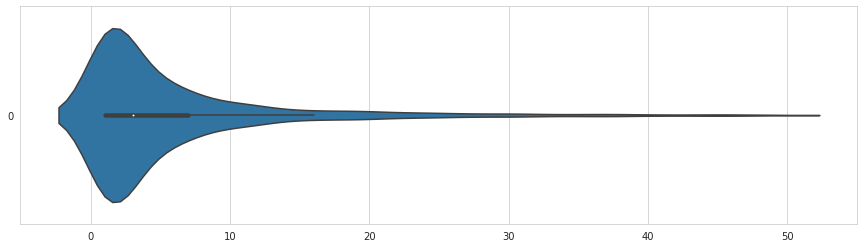

In [46]:
rest_per_street = df.groupby('street',as_index=False)['id'].count()
rest_per_street.columns = ['street', 'n_rests']
plt.figure(figsize=(15, 4))
sns.violinplot(data = rest_per_street[rest_per_street['n_rests'] < 50]['n_rests'], orient = 'h')

In [47]:
print('Судя по графику, под "улицей с большим количеством объектов общественного питания" можно понимать верхние 10% улиц с {:.0f} и более заведениями.'.format(rest_per_street['n_rests'].quantile(0.9)))

Судя по графику, под "улицей с большим количеством объектов общественного питания" можно понимать верхние 10% улиц с 17 и более заведениями.


Делаю новый датафрейм, в который подтягиваю количество ресторанов на каждой улице, и строю графики распределения количества мест в заведении по (а) всем заведениям (оранженвый цвет), и (б) только по заведениям, которые находятся на улице с более чем 17 ресторанами. Все графики ограничены ресторанами до 100 мест.

0.5599807676897187


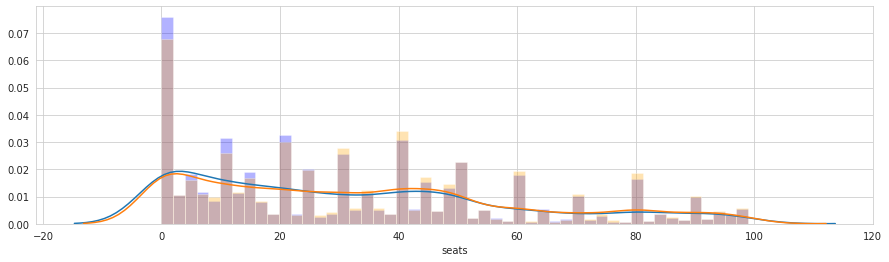

In [48]:
streets_rests = df.merge(rest_per_street, on = 'street', how = 'left')
plt.figure(figsize=(15, 4))
sns.distplot(streets_rests.query('seats < 100 and n_rests > 17')['seats'], hist_kws={"alpha": 0.3, "color": "blue"}, bins = 50)
sns.distplot(streets_rests.query('seats < 100')['seats'], hist_kws={"alpha": 0.3, "color": "orange"}, bins = 50)
print(len(streets_rests.query('seats < 100 and n_rests > 17')) / len(streets_rests.query('seats < 100')))

Как видно на графике, распределение практически совпадает, с той лишь разницей, что на популярных улицах чуть больше маленьких заведений (до 30 мест) и чуть меньше - больших (больше 30 мест). В остальном распределение совпадает. Это ожидаемо, потому что, с одной стороны, на загруженных улицах меньше места для больших ресторанов, а с другой, на 10% самых популярных улиц находится 56% всех ресторанов, поэтому распределение этой выборки не должно сильно отличаться от распределения всей популяции.

### Общий вывод <a id="2_8"></a>  
Основные выводы представлены в разделах выше. Общий вывод следующий:  
Небольшие (на ~30 посетителей) несетевые (77%) кафе – это наиболее массовые заведения в Москве. Это говорит и об их популярности, и о высокой конкуренции. Необычный формат с роботами может стать успешным конкуретным преимуществом, поэтому имеет смысл не избегать конкуренции, а разместить кафе в одном из наиболее популярных районов - Пресненском, Басманном, Даниловском или Тверском. При успехе первого заведения в дальнейшем можно расширяться, следуя одной из двух стратегий: увеличивать размер кафе или расширять сеть, однако, судя по опыту конкурентов, не то и другое одновременно. 

## Шаг №3. Презентация <a id="3"></a>  

[Презентация доступна по ссылке](https://yadi.sk/i/MsIuE2M61dWs3Q)